In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


2025-04-28 09:19:46.687744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745831987.050191      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745831987.150232      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean


df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)

df['AWS2'] = df['AWS']

features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['doy']  = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2 * np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2 * np.pi * df['doy']  / 365)


In [3]:
split_time = pd.Timestamp('2020-10-15 23:00:00')
df_train = df[df['datetime'] <= split_time].reset_index(drop=True)
df_test  = df[df['datetime'] >  split_time].reset_index(drop=True)

df_test_orig = df_test.copy()

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features]  = scaler.transform(df_test[features])


In [4]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    times = data['datetime'].tolist()
    for i in range(window_size, len(data) - horizon + 1):
        if any((times[j] - times[j-1]).total_seconds() != 3600 
               for j in range(i-window_size+1, i+horizon)):
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)

window_size = 1
horizon     = 6

X_train, y_train = make_sequences(df_train, features, target, window_size, horizon)
X_test,  y_test  = make_sequences(df_test,  features, target, window_size, horizon)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (351315, 1, 14) (351315, 6)
Test  shapes: (74038, 1, 14) (74038, 6)


Trial 20 Complete [00h 05m 59s]
val_r2_keras: -3251647.0

Best val_r2_keras So Far: -3195104.25
Total elapsed time: 02h 01m 44s
Best hp: {'units1': 64, 'units2': 128, 'dropout': 0.4, 'learning_rate': 0.0001}
Best hyperparameters:
  units1        = 64
  dropout       = 0.40
  units2        = 128
  learning_rate = 0.0001
Epoch 1/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: 0.3038 - mae: 0.3126 - r2_keras: -437338.5312 - val_loss: 0.2440 - val_mae: 0.1603 - val_r2_keras: -3964435.0000
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.1491 - mae: 0.1405 - r2_keras: -30849.4551 - val_loss: 0.2474 - val_mae: 0.1610 - val_r2_keras: -3501587.0000
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.1412 - mae: 0.1207 - r2_keras: -20373.3516 - val_loss: 0.2529 - val_mae: 0.1666 - val_r2_keras: -3831099.2500
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 0.1364 - mae: 0.1137 - r2_keras: -29341.2090 - val_loss: 0.2567 - val_mae: 0.1703 - va

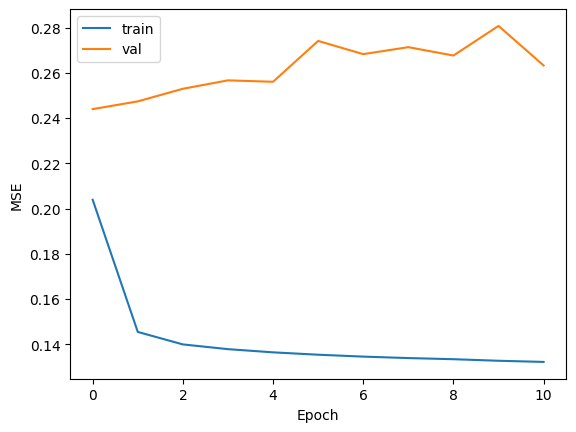

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def build_model_hp(hp):
    model = Sequential()
    # Cố định 2 lớp LSTM
    # LSTM 1
    u1 = hp.Choice('units1', [64, 128])
    model.add(LSTM(u1, return_sequences=True,
                   input_shape=(window_size, len(features))))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout', 0.2, 0.4, step=0.1)))  # chung

    # LSTM 2
    u2 = hp.Choice('units2', [64, 128])
    model.add(LSTM(u2, return_sequences=False))
    model.add(BatchNormalization())
    # không thêm dropout nữa cho lớp 2

    model.add(Dense(horizon, activation='linear'))

    lr = hp.Choice('learning_rate', [1e-3, 1e-4])  # chỉ 2 lựa chọn
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae', r2_keras]
    )
    return model

tuner_bo = BayesianOptimization(
    build_model_hp,
    objective=Objective('val_r2_keras', direction='max'),
    max_trials=20,             # chỉ thử tối đa 20 cấu hình
    num_initial_points=5,      # khởi tạo 5 random trước
    directory='bayes_tuner',
    project_name='rainfall_bayes'
)

tuner_bo.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_r2_keras', mode='max',
                      patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', mode='min',
                          factor=0.5, patience=3, min_lr=1e-6)
    ],
    verbose=1
)

# Lấy kết quả
best_hp = tuner_bo.get_best_hyperparameters(1)[0]
print("Best hp:", {p: best_hp.get(p) for p in [
    'units1','units2','dropout','learning_rate'
]})
model   = tuner_bo.hypermodel.build(best_hp)
print("Best hyperparameters:")
print(f"  units1        = {best_hp.get('units1')}")
print(f"  dropout       = {best_hp.get('dropout'):.2f}")
print(f"  units2        = {best_hp.get('units2')}")
print(f"  learning_rate = {best_hp.get('learning_rate')}")

# 6) Train best model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[ EarlyStopping('val_loss',patience=10,restore_best_weights=True) ],
    verbose=1
)

# 7) Plot losses
plt.plot(history.history['loss'],  label='train')
plt.plot(history.history['val_loss'],label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

In [6]:
from scipy.stats import pearsonr

y_pred = model.predict(X_test)         
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2  : {r2:.4f}")


y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
print(f"Overall Pearson R: {pearson_r:.4f}")


2314/2314 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Test MSE  : 0.3019
Test RMSE : 0.5495
Test MAE  : 0.2205
Test R^2  : 0.3277
Overall Pearson R: 0.5846


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_13/2836009533.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


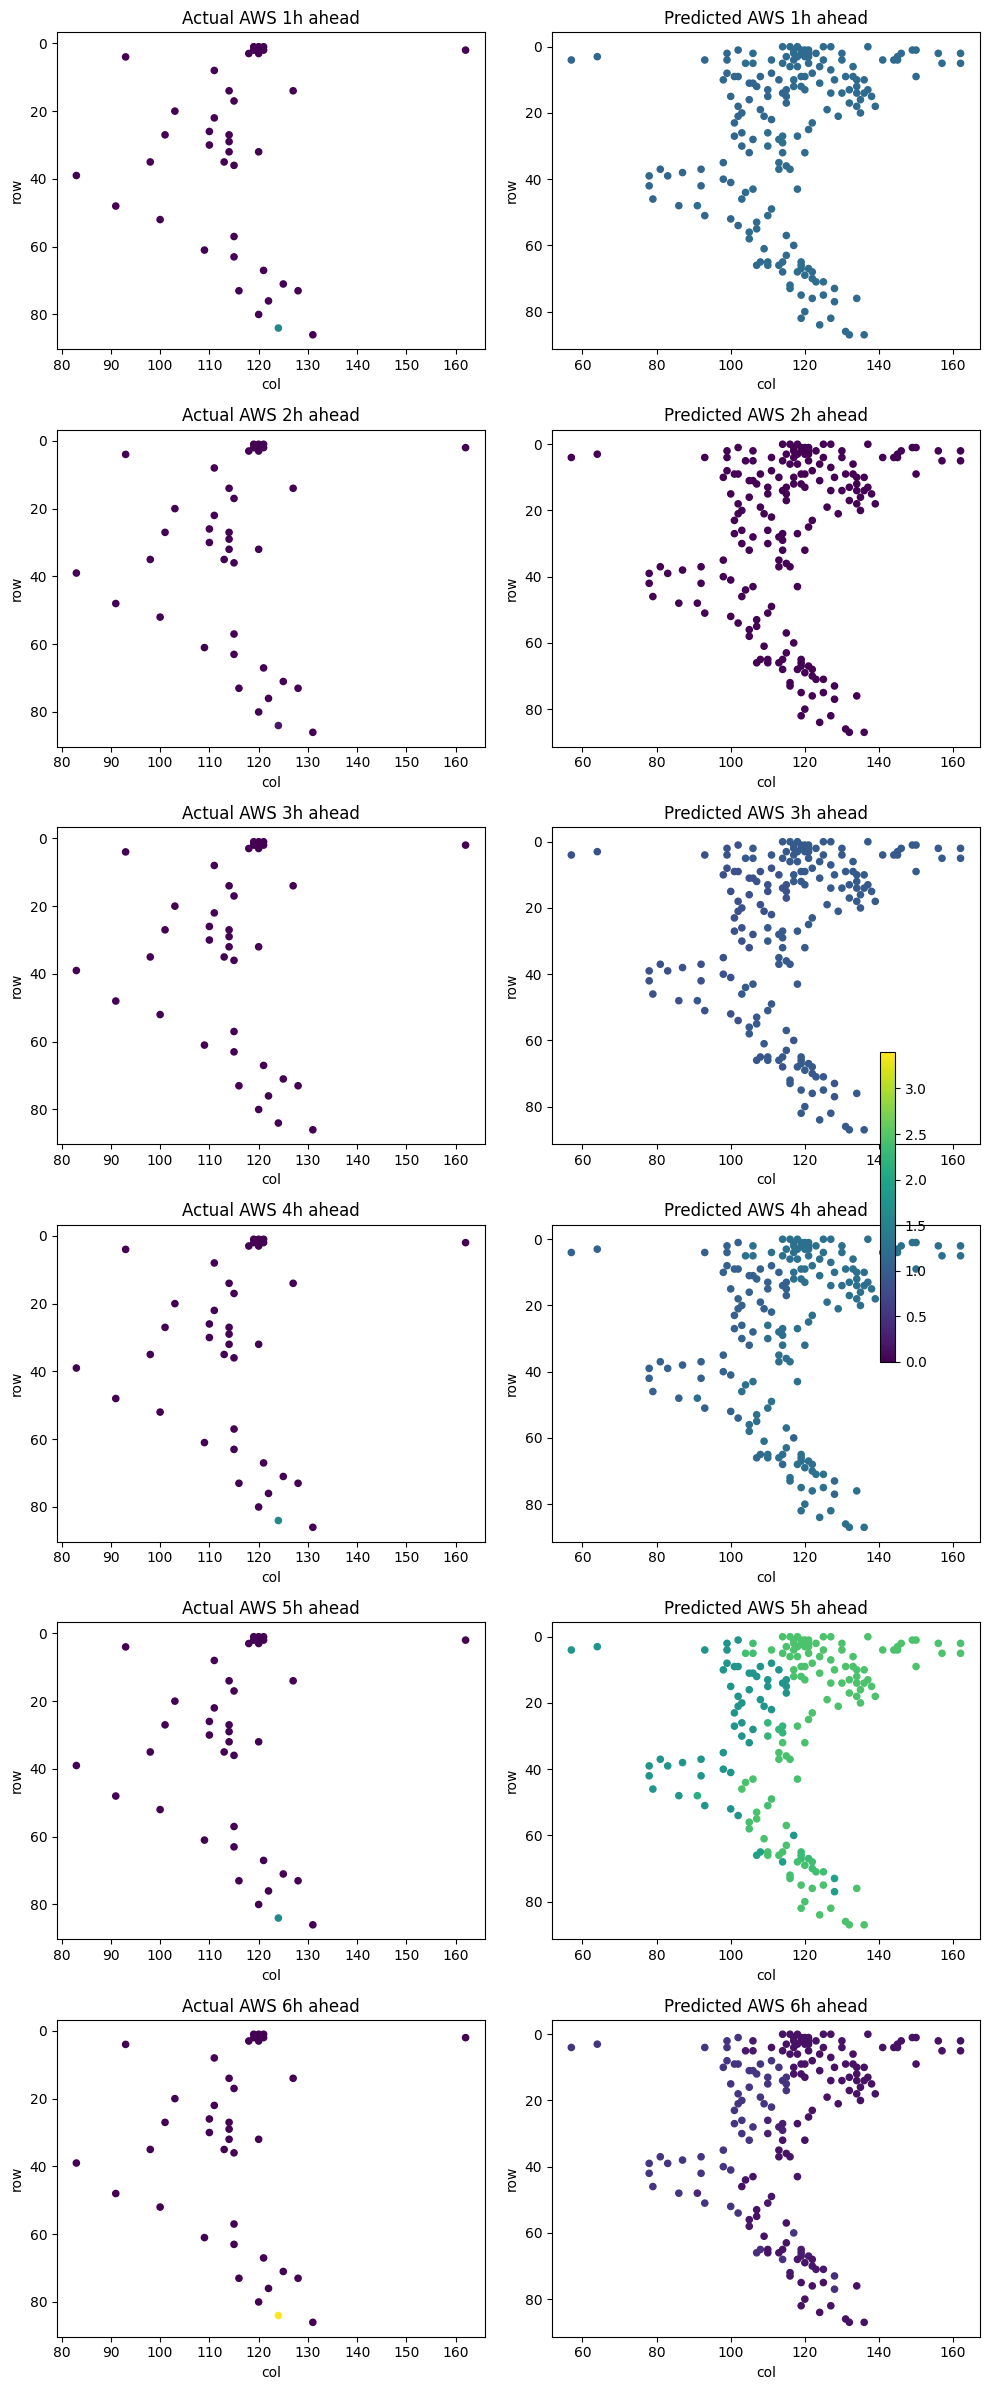

In [7]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
